In [5]:
import os
import numpy as np
import pandas as pd
import functools
from osgeo import gdal, ogr
import geopandas as gpd
import rasterio
from rasterio.enums import Resampling
#from rasterio.plot import show
import cartopy.crs as ccrs 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt 
import matplotlib as mpl
from matplotlib.colors import ListedColormap

from process_functions import * 

import sys
os.chdir(r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\crop_rotation')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Cluster Template
cluster = rasterio.open(r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\cluster.tif').read(1)
print(cluster.shape)
new_width = cluster.shape[1]
new_height = cluster.shape[0]

(362, 896)


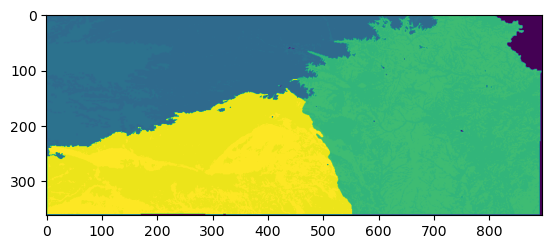

In [4]:
plt.imshow(cluster)

In [6]:
ks_2022= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2022wgs84_ks_scaled.tif").read(1)
ks_2021= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2021wgs84_ks_scaled.tif").read(1)
ks_2020= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2020wgs84_ks_scaled.tif").read(1)     
ks_2019= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2019wgs84_ks_scaled.tif").read(1)
ks_2018= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2018wgs84_ks_scaled.tif").read(1)
ks_2017= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2017wgs84_ks_scaled.tif").read(1)

rotation = np.stack(( ks_2022, ks_2021, ks_2020, ks_2019, ks_2018, ks_2017))

ks_2022= rasterio.open(r"C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/2022wgs84_ks.tif").read(1, out_shape=(1,new_height, new_width), resampling=Resampling.mode)
ks_2021= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2021wgs84_ks.tif").read(1, out_shape=(1,new_height, new_width), resampling=Resampling.mode)
ks_2020= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2020wgs84_ks.tif").read(1, out_shape=(1,new_height, new_width), resampling=Resampling.mode)     
ks_2019= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2019wgs84_ks.tif").read(1, out_shape=(1,new_height, new_width), resampling=Resampling.mode)
ks_2018= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2018wgs84_ks.tif").read(1, out_shape=(1,new_height, new_width), resampling=Resampling.mode)
ks_2017= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2017wgs84_ks.tif").read(1, out_shape=(1,new_height, new_width), resampling=Resampling.mode)

rotation = np.stack(( ks_2022, ks_2021, ks_2020, ks_2019, ks_2018, ks_2017))

print(rotation[0].shape)
new_width = rotation[0].shape[1]
new_height = rotation[0].shape[0]

# Reopen cluster and sample to the CDL dimension - 30-meter
cluster = rasterio.open(r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\cluster.tif').read(1, out_shape=(1,new_height, new_width), resampling=Resampling.mode)
print(cluster.shape)

In [7]:
def CropCount(np_array, vals):
    mask = functools.reduce(np.logical_or, (np_array==val for val in vals))
    non_crop = (np.where(mask, 1,0)).astype(dtype=np.uint8)
    return non_crop 

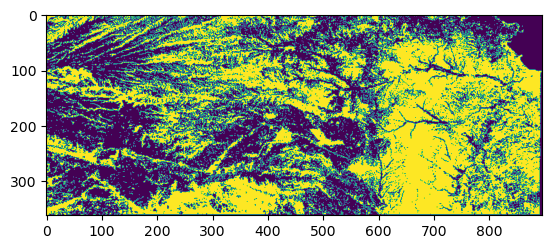

In [8]:
ks_non_crop = CropCount(ks_2022,[63, 64, 65, 111,112, 121, 122, 123, 124, 131, 141, 142, 143, 152, 176, 190, 195])
plt.imshow(ks_non_crop)

In [9]:
# Get top 10 crops 
mask = (ks_non_crop == 1) 
unique, counts = np.unique(ks_2022[~mask], return_counts=True)
unq = pd.DataFrame(counts,unique)
unq
unq.sort_values(by=[0])

,0
44.0,1
43.0,2
254.0,3
53.0,3
57.0,5
21.0,6
238.0,6
59.0,9
31.0,26
225.0,29


In [10]:
wheat = [CropCount(r, [24]) for r in rotation]
wheat = sum(wheat)

corn = [CropCount(r, [1]) for r in rotation]
corn = sum(corn)

soybeans = [CropCount(r, [5]) for r in rotation]
soybeans = sum(soybeans)

fallow = [CropCount(r, [61]) for r in rotation]
fallow = sum(fallow)

sorghum = [CropCount(r, [4]) for r in rotation]
sorghum = sum(sorghum)

wht_soy = [CropCount(r, [26]) for r in rotation]
wht_soy= sum(wht_soy)

alfalfa = [CropCount(r, [36]) for r in rotation]
alfalfa= sum(alfalfa)

other_hay = [CropCount(r, [37]) for r in rotation]
other_hay= sum(other_hay)

tricale = [CropCount(r, [205]) for r in rotation]
tricale= sum(tricale)

cotton = [CropCount(r, [2]) for r in rotation]
cotton= sum(cotton)

cotton = [CropCount(r, [2]) for r in rotation]
cotton= sum(cotton)

crop_features =[wheat, corn, soybeans, fallow, sorghum, wht_soy, alfalfa, other_hay, tricale, cotton]

In [11]:
# Create mask 
mask = (cluster == 0) | (ks_non_crop == 1) 

cluster_m = cluster[~mask]

crop_features =[wheat, corn, soybeans, fallow, sorghum, wht_soy, alfalfa, other_hay, tricale, cotton]
crop_features_m = [c[~mask] for c in crop_features] 

**Multinomial Validation for Macro Classes**

In [12]:
y = np.round(cluster_m/10,0) # reduce to classes 1, 2, 3
y = y.astype(int).astype(str) # change to categorical variable 

indices = [x for x,i in np.ndenumerate(y)] # This is used for plotting

X = np.stack((crop_features_m[0].flatten(),crop_features_m[1].flatten(),crop_features_m[2].flatten(),crop_features_m[3].flatten(), crop_features_m[4].flatten(), crop_features_m[5].flatten(), 
              crop_features_m[6].flatten(), crop_features_m[7].flatten(), crop_features_m[8].flatten(),crop_features_m[9].flatten()), axis=1)

X_train, X_test, y_train, y_test,indices_train, indices_test= train_test_split(X, y, indices, test_size=0.25, random_state=2, stratify=y)

# Select Optimal Model Parameters
class_weight = {'1':np.count_nonzero(y== '1')/np.count_nonzero(y),'2':np.count_nonzero(y== '2')/np.count_nonzero(y), '3':np.count_nonzero(y== '3')/np.count_nonzero(y)} # class weights
model = LogisticRegression() 

# Set a CV to be utilized
cv = 10

# Set Paramters
parameters = {'penalty' : ['l2',  'none'],
              'solver' : ['lbfgs',  'newton-cg', 'sag', 'saga'],
              'max_iter':[500, 1000],
              'multi_class':['multinomial'], 
              'class_weight':[class_weight], 
             }
params_ = GridSearchCV(estimator=model, param_grid = parameters, cv = cv, n_jobs=-1)
params_.fit(X_train, y_train)
params_.best_params_

{'class_weight': {'1': 0.36847410902258215,
  '2': 0.2899954053887247,
  '3': 0.34153048558869314},
 'max_iter': 500,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'sag'}

In [13]:
#Cross Validate
macro_scores = cross_validate(LogisticRegression(**params_.best_params_), X_test, y_test, cv = 10,
               scoring=['r2', 'neg_mean_squared_error', 'accuracy', 'mutual_info_score'])

for key,vals in macro_scores.items():
    print("Average for {} is {}".format(key,round(np.mean(vals),2)))

Average for fit_time is 0.33
Average for score_time is 0.02
Average for test_r2 is -0.44
Average for test_neg_mean_squared_error is -1.02
Average for test_accuracy is 0.65
Average for test_mutual_info_score is 0.28


In [14]:
# Classification Report 
logmodel_macro = LogisticRegression(**params_.best_params_, random_state=2) 
logmodel_macro.fit(X_train, y_train)

predictions_log_macro=logmodel_macro.predict(X_test)
importance= logmodel_macro.coef_ # save for evaluation of variables

print(classification_report(y_test, predictions_log_macro))

              precision    recall  f1-score   support

           1       0.58      0.70      0.63     13433
           2       0.77      0.81      0.79     10572
           3       0.63      0.46      0.53     12451

    accuracy                           0.65     36456
   macro avg       0.66      0.65      0.65     36456
weighted avg       0.65      0.65      0.64     36456



In [15]:
# Get data for y actual vs predicted values

In [16]:
# Merge Back with Cluster For Plotting 
pred_array =np.full(y.shape,  -9999)
true_array =np.full(y.shape,  -9999)
test_inds = tuple(zip(*indices_test))
train_inds = tuple(zip(*indices_train))

pred_array[test_inds]= predictions_log_macro 
pred_array[train_inds]=  -9999

true_array[test_inds]= y_test
true_array[train_inds]=  -9999

pred_macro =np.full(cluster.shape, -9999)
actual_macro =np.full(cluster.shape,  -9999)

mask_idx = np.argwhere(mask==False)
mask_idx= tuple(zip(*mask_idx))

pred_macro[mask_idx] =  pred_array.astype(int)
actual_macro[mask_idx] =  true_array.astype(int)

In [17]:
# Write to Shape Files for Plots

# Macro Predictions
file_str= 'C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/pred_macro.tif'
rasterfn = r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\cluster.tif'
array = pred_macro
array2raster(file_str,rasterfn,array)

string = 'pred_macro'
path =  'C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/pred_macro.tif'
rast2vec(path, string)


# Macro Ground Truth
file_str= 'C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/actual_macro.tif'
rasterfn = r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\cluster.tif'
array = actual_macro
array2raster(file_str,rasterfn,array)

string = 'actual_macro'
path =  'C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/actual_macro.tif'
rast2vec(path, string)

<Figure size 200x200 with 0 Axes>

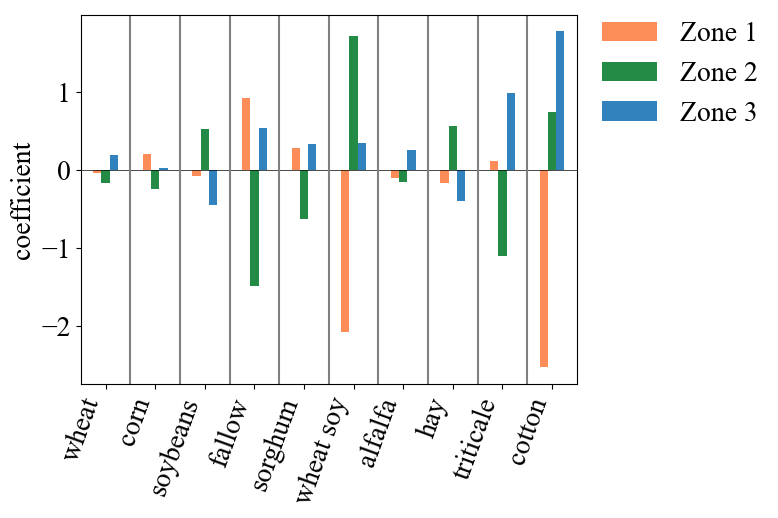

In [18]:
plt.figure(figsize=(2,2), constrained_layout=True) 

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 20

plotdata = pd.DataFrame({'Zone 1': importance[0], 
                         'Zone 2': importance[1], 
                         'Zone 3': importance[2]},index = ['wheat', 'corn', 'soybeans', 'fallow', 'sorghum', 'wheat soy', 'alfalfa', 'hay', 'triticale', 'cotton']) 

plotdata.plot(kind="bar", color=['#fc8d59',  "#238b45",  '#3182bd'])
plt.axhline(y = 0, color = 'black', linestyle = '-', linewidth=.5)

plt.axvline(x = .5, color = 'gray', linestyle = '-')
plt.axvline(x = 1.5, color = 'gray', linestyle = '-')
plt.axvline(x = 2.5, color = 'gray', linestyle = '-')
plt.axvline(x = 3.5, color = 'gray', linestyle = '-')
plt.axvline(x = 4.5, color = 'gray', linestyle = '-')
plt.axvline(x = 5.5, color = 'gray', linestyle = '-')
plt.axvline(x = 6.5, color = 'gray', linestyle = '-')
plt.axvline(x = 7.5, color = 'gray', linestyle = '-')
plt.axvline(x = 8.5, color = 'gray', linestyle = '-')

#plt.title("Validation Feature Importance")
plt.ylabel("coefficient")

plt.legend(bbox_to_anchor=(1, 1.05), frameon=False)
plt.xticks(rotation=70, ha='right')
plt.savefig('macro_feature_importance.jpg', dpi=500, bbox_inches="tight")
plt.show()


**Multinomial Validation for Macro-Micro Classes**

In [19]:
y = cluster_m.astype(str)

indices = [x for x,i in np.ndenumerate(y)] # This is used for plotting

X = np.stack((crop_features_m[0].flatten(),crop_features_m[1].flatten(),crop_features_m[2].flatten(),crop_features_m[3].flatten(), crop_features_m[4].flatten(), crop_features_m[5].flatten(), 
              crop_features_m[6].flatten(), crop_features_m[7].flatten(), crop_features_m[8].flatten(),crop_features_m[9].flatten()), axis=1)

X_train, X_test, y_train, y_test,indices_train, indices_test= train_test_split(X, y, indices, test_size=0.25, random_state=2, stratify=y)

# Select Optimal Model Parameters
class_weight = {'11':np.count_nonzero(y== '11')/np.count_nonzero(y),'12':np.count_nonzero(y== '12')/np.count_nonzero(y), '21':np.count_nonzero(y== '21')/np.count_nonzero(y),
               '22':np.count_nonzero(y== '22')/np.count_nonzero(y),'31':np.count_nonzero(y== '31')/np.count_nonzero(y), '32':np.count_nonzero(y== '32')/np.count_nonzero(y)} 

model = LogisticRegression() 

# Set a CV to be utilized
cv = 10

# Set Paramters
parameters = {'penalty' : ['l2',  'none'],
              'solver' : ['lbfgs',  'newton-cg', 'sag', 'saga'],
              'max_iter':[500, 1000],
              'multi_class':['multinomial'], 
              'class_weight':[class_weight], 
             }
params_mac_mic = GridSearchCV(estimator=model, param_grid = parameters, cv = cv, n_jobs=-1)
params_mac_mic.fit(X_train, y_train)
params_mac_mic.best_params_


{'class_weight': {'11': 0.20467278824328125,
  '12': 0.16380132077930093,
  '21': 0.19844606132091647,
  '22': 0.09154934406780824,
  '31': 0.2506120433676443,
  '32': 0.0909184422210488},
 'max_iter': 500,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [20]:
#Cross Validate
mac_mic_scores = cross_validate(LogisticRegression(**params_mac_mic.best_params_), X_test, y_test, cv = 10,
               scoring=['r2', 'neg_mean_squared_error', 'accuracy', 'mutual_info_score'])

for key,vals in mac_mic_scores.items():
    print("Average for {} is {}".format(key,round(np.mean(vals),2)))

Average for fit_time is 2.15
Average for score_time is 0.01
Average for test_r2 is -0.58
Average for test_neg_mean_squared_error is -110.57
Average for test_accuracy is 0.45
Average for test_mutual_info_score is 0.33


In [21]:
logmodel_mac_mic = LogisticRegression(**params_mac_mic.best_params_, random_state=2) 
logmodel_mac_mic.fit(X_train, y_train)

predictions_log_mac_mic=logmodel_mac_mic.predict(X_test)
importance_macro_micro= logmodel_mac_mic.coef_ # save for evaluation of variables
print(classification_report(y_test, predictions_log_mac_mic))

              precision    recall  f1-score   support

          11       0.34      0.15      0.21      7462
          12       0.46      0.35      0.40      5972
          21       0.53      0.81      0.64      7235
          22       0.00      0.00      0.00      3337
          31       0.41      0.78      0.54      9136
          32       0.63      0.04      0.07      3314

    accuracy                           0.45     36456
   macro avg       0.39      0.35      0.31     36456
weighted avg       0.41      0.45      0.38     36456



In [22]:
# Merge Back with Cluster For Plotting 

pred_array =np.full(y.shape, -9999)
true_array =np.full(y.shape, -9999)
test_inds = tuple(zip(*indices_test))
train_inds = tuple(zip(*indices_train))

pred_array[test_inds]= predictions_log_macro
pred_array[train_inds]= -9999

true_array[test_inds]= y_test
true_array[train_inds]=  -9999

pred_mac_mic =np.full(cluster.shape, -9999)
actual_mac_mic =np.full(cluster.shape, -9999)

mask_idx = np.argwhere(mask==False)
mask_idx= tuple(zip(*mask_idx))

pred_mac_mic[mask_idx] =  pred_array.astype(int)
actual_mac_mic[mask_idx] =  true_array.astype(int)

In [23]:
# Write to Shape Files for Plots

# Macro Predictions
file_str= 'C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/pred_mac_mic.tif'
rasterfn = r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\cluster.tif'
array = pred_mac_mic
array2raster(file_str,rasterfn,array)

string = 'pred_mac_mic'
path =  'C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/pred_mac_mic.tif'
rast2vec(path, string)


# Macro Ground Truth
file_str= 'C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/actual_mac_mic.tif'
rasterfn = r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\cluster.tif'
array = actual_mac_mic
array2raster(file_str,rasterfn,array)

string = 'actual_mac_mic'
path =  'C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/actual_mac_mic.tif'
rast2vec(path, string)

<Figure size 50x100 with 0 Axes>

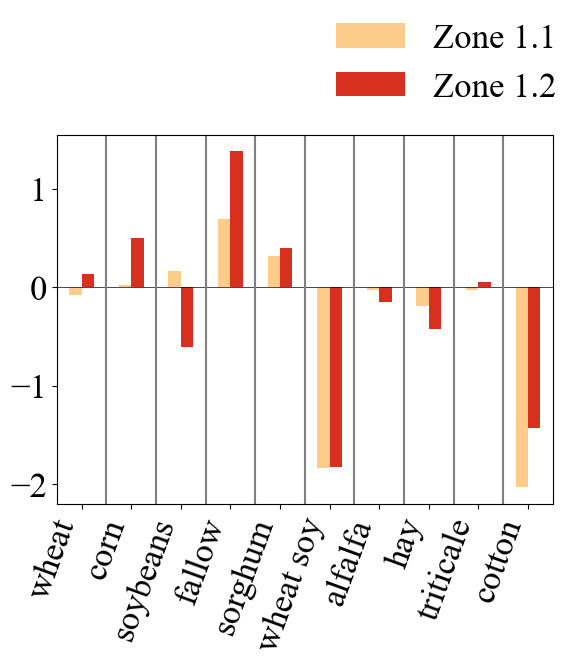

In [24]:
plt.figure(figsize=(.5,1), constrained_layout=True) 

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 25

plotdata = pd.DataFrame({'Zone 1.1': importance_macro_micro[0], 
                         'Zone 1.2': importance_macro_micro[1], 
                        },index = ['wheat', 'corn', 'soybeans', 'fallow', 'sorghum', 'wheat soy', 'alfalfa', 'hay', 'triticale', 'cotton']) 

plotdata.plot(kind="bar", color=['#fdcc8a',  '#d7301f',  ])
plt.axhline(y = 0, color = 'black', linestyle = '-', linewidth=.5)

plt.axvline(x = .5, color = 'gray', linestyle = '-')
plt.axvline(x = 1.5, color = 'gray', linestyle = '-')
plt.axvline(x = 2.5, color = 'gray', linestyle = '-')
plt.axvline(x = 3.5, color = 'gray', linestyle = '-')
plt.axvline(x = 4.5, color = 'gray', linestyle = '-')
plt.axvline(x = 5.5, color = 'gray', linestyle = '-')
plt.axvline(x = 6.5, color = 'gray', linestyle = '-')
plt.axvline(x = 7.5, color = 'gray', linestyle = '-')
plt.axvline(x = 8.5, color = 'gray', linestyle = '-')

#plt.ylabel("coefficient")

plt.legend(bbox_to_anchor=(.5, 1), frameon=False)
plt.xticks(rotation=70, ha='right')
plt.savefig('macro1_micro_feature_importance.jpg', dpi=500, bbox_inches="tight")
plt.show()


<Figure size 50x100 with 0 Axes>

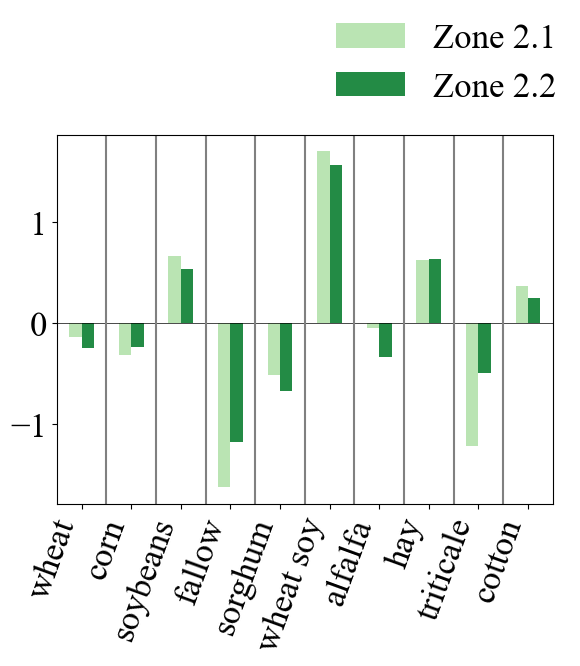

In [25]:
plt.figure(figsize=(.5,1), constrained_layout=True) 

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 25

plotdata = pd.DataFrame({
                         'Zone 2.1': importance_macro_micro[2], 
                        'Zone 2.2': importance_macro_micro[3]},index = ['wheat', 'corn', 'soybeans', 'fallow', 'sorghum', 'wheat soy', 'alfalfa', 'hay', 'triticale', 'cotton']) 

plotdata.plot(kind="bar", color=[ '#bae4b3',"#238b45", ])
plt.axhline(y = 0, color = 'black', linestyle = '-', linewidth=.5)



plt.axvline(x = .5, color = 'gray', linestyle = '-')
plt.axvline(x = 1.5, color = 'gray', linestyle = '-')
plt.axvline(x = 2.5, color = 'gray', linestyle = '-')
plt.axvline(x = 3.5, color = 'gray', linestyle = '-')
plt.axvline(x = 4.5, color = 'gray', linestyle = '-')
plt.axvline(x = 5.5, color = 'gray', linestyle = '-')
plt.axvline(x = 6.5, color = 'gray', linestyle = '-')
plt.axvline(x = 7.5, color = 'gray', linestyle = '-')
plt.axvline(x = 8.5, color = 'gray', linestyle = '-')


#plt.ylabel("coefficient")

plt.legend(bbox_to_anchor=(.5, 1), frameon=False)
plt.xticks(rotation=70, ha='right')
plt.savefig('macro2_micro_feature_importance.jpg', dpi=500, bbox_inches="tight")
plt.show()

<Figure size 50x100 with 0 Axes>

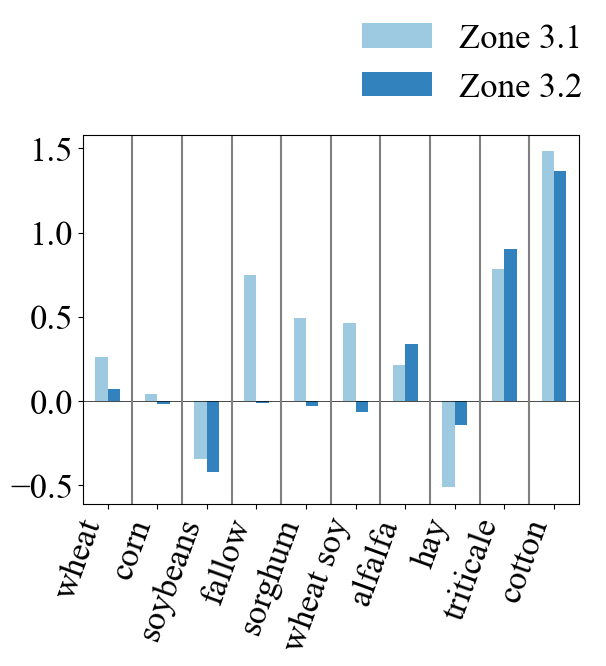

In [26]:
plt.figure(figsize=(.5,1), constrained_layout=True) 

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 25

plotdata = pd.DataFrame({
                        'Zone 3.1': importance_macro_micro[4], 
                        'Zone 3.2': importance_macro_micro[5]},index = ['wheat', 'corn', 'soybeans', 'fallow', 'sorghum', 'wheat soy', 'alfalfa', 'hay', 'triticale', 'cotton']) 

plotdata.plot(kind="bar", color=['#9ecae1', '#3182bd'])
plt.axhline(y = 0, color = 'black', linestyle = '-', linewidth=.5)



plt.axvline(x = .5, color = 'gray', linestyle = '-')
plt.axvline(x = 1.5, color = 'gray', linestyle = '-')
plt.axvline(x = 2.5, color = 'gray', linestyle = '-')
plt.axvline(x = 3.5, color = 'gray', linestyle = '-')
plt.axvline(x = 4.5, color = 'gray', linestyle = '-')
plt.axvline(x = 5.5, color = 'gray', linestyle = '-')
plt.axvline(x = 6.5, color = 'gray', linestyle = '-')
plt.axvline(x = 7.5, color = 'gray', linestyle = '-')
plt.axvline(x = 8.5, color = 'gray', linestyle = '-')


#plt.ylabel("coefficient")

plt.legend(bbox_to_anchor=(.5, 1), frameon=False)
plt.xticks(rotation=70, ha='right')
plt.savefig('macro3_micro_feature_importance.jpg', dpi=500, bbox_inches="tight")
plt.show()

<Figure size 50x100 with 0 Axes>

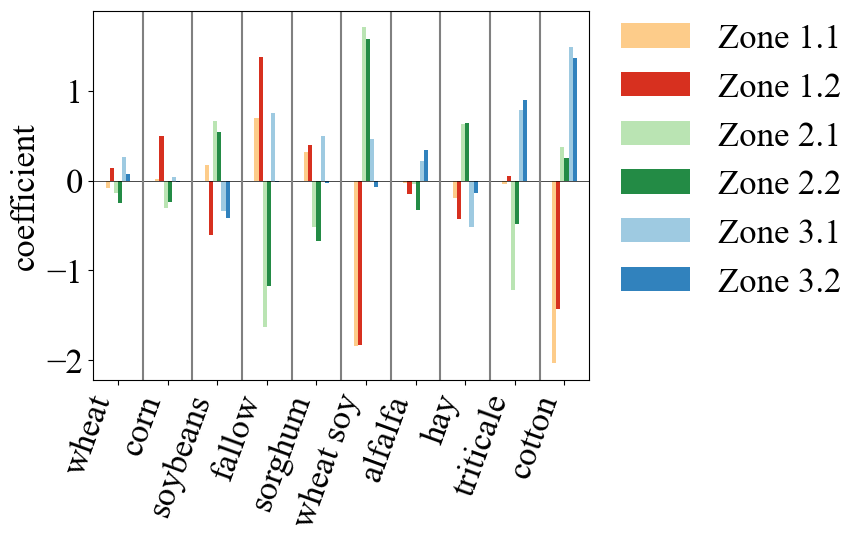

In [27]:
plt.figure(figsize=(.5,1), constrained_layout=True) 

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 25

plotdata = pd.DataFrame({'Zone 1.1': importance_macro_micro[0], 
                         'Zone 1.2': importance_macro_micro[1], 
                         'Zone 2.1': importance_macro_micro[2], 
                        'Zone 2.2': importance_macro_micro[3], 
                        'Zone 3.1': importance_macro_micro[4], 
                        'Zone 3.2': importance_macro_micro[5]},index = ['wheat', 'corn', 'soybeans', 'fallow', 'sorghum', 'wheat soy', 'alfalfa', 'hay', 'triticale', 'cotton']) 

plotdata.plot(kind="bar", color=['#fdcc8a',  '#d7301f',   '#bae4b3',"#238b45",  '#9ecae1', '#3182bd'])
plt.axhline(y = 0, color = 'black', linestyle = '-', linewidth=.5)



plt.axvline(x = .5, color = 'gray', linestyle = '-')
plt.axvline(x = 1.5, color = 'gray', linestyle = '-')
plt.axvline(x = 2.5, color = 'gray', linestyle = '-')
plt.axvline(x = 3.5, color = 'gray', linestyle = '-')
plt.axvline(x = 4.5, color = 'gray', linestyle = '-')
plt.axvline(x = 5.5, color = 'gray', linestyle = '-')
plt.axvline(x = 6.5, color = 'gray', linestyle = '-')
plt.axvline(x = 7.5, color = 'gray', linestyle = '-')
plt.axvline(x = 8.5, color = 'gray', linestyle = '-')


plt.ylabel("coefficient")

plt.legend(bbox_to_anchor=(1, 1.05), frameon=False)
plt.xticks(rotation=70, ha='right')
#plt.savefig('macro_micro_feature_importance.jpg', dpi=500, bbox_inches="tight")
plt.show()
